# Analiza Visitorjev

In [1]:
import pandas as pd
import os.path
import re
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from matplotlib.colors import Normalize
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LogNorm


# pd.options.display.max_rows = 10
#%matplotlib notebook
%matplotlib inline

# naložimo razpredelnico, s katero bomo delali
pot_do_Visitorjev = os.path.join("immadegen.csv")
visitorji = pd.read_csv(pot_do_Visitorjev)
visitorji = visitorji.set_index('Name')

## Obdelava podatkov

In [2]:
visitorji

,Background,Clothing,Expression,Eyes,Eyewear,Head,Mouth,Neck,Nose,Skin,Type,Price
Name,,,,,,,,,,,,
Visitor1,Pink,NaN,Delusional,Visitor,NaN,Barbarian,Face Mask,Gold Necklace,NaN,Green,Not for sale,NaN
Visitor2,Pink,Black T-shirt,Surprised,Twirl,Eyepatch,NaN,NaN,NaN,NaN,Blue,Buy,5.000
Visitor3,Purple,Mariniere,Surprised,Lime,Aviators,Bucket Hat,Face Mask,NaN,NaN,War Paint,Not for sale,NaN
Visitor4,Green,NaN,Surprised,Navy,Round Glasses,Bolero,Gagged,NaN,Gold Brow Stud,Blue,Not for sale,NaN
Visitor5,Red,Hoodie Down,Confident,Stoned,Round Glasses,Barbarian,Pipe,NaN,Silver Brow Stud,Blue,Not for sale,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
Visitor9995,Green,Suit,Surprised,White,Skelly,Do Rag,Fangs,NaN,Clown,Green,Buy,10.000
Visitor9996,Purple,Hoodie With Jacket,Surprised,Lime,NaN,Top Hat,NaN,NaN,Silver Brow Stud,Cyberpunk,Buy,1.000
Visitor9997,Purple,Suit,Tired,Navy,Monocle,Floppy Hat,Gagged,NaN,Silver Brow Stud,Trippy,Not for sale,NaN


## Analiza

Ugotvljanje pogostosti lastnosti

In [3]:
lastnosti = visitorji.columns[0:11]

In [4]:
for lastnost in lastnosti:
    vars()[lastnost] = round(visitorji[lastnost].value_counts()/9999*100, 2)


def redkost(Dataset):
    return pd.DataFrame(round(visitorji[Dataset].value_counts()/9999*100, 2))


In [6]:
widgets.interact(redkost, Dataset = widgets.ToggleButtons(
    options=lastnosti,
    description='Lastnost:',
    disabled=False, 
    #button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Description of slow', 'Description of regular', 'Description of fast']))

interactive(children=(ToggleButtons(description='Lastnost:', options=('Background', 'Clothing', 'Expression', …

<function __main__.redkost(Dataset)>

Na spodnjem grafu lahko vidimo, da večina Visitorjev ni na prodaj. Pri naši analizi pa bomo v glavnem uporabljali presotali delež.

<AxesSubplot:ylabel='Type'>

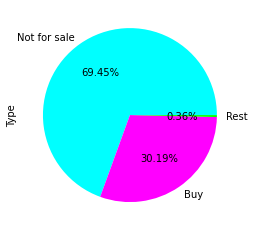

In [7]:
prikaz_tipa = Type[Type>1]
prikaz_tipa['Rest'] = Type[Type <= 1].sum()

prikaz_tipa.plot.pie(autopct = "%.2f%%", colors = ['aqua', 'fuchsia', 'lime'])

##### Ugotavljanje pomembnosti ozadja

In [8]:
buy = visitorji.loc[visitorji['Type'] == 'Buy']
top_bid = visitorji.loc[visitorji['Type'] == 'Top bid']
min_bid = visitorji.loc[visitorji['Type'] == 'Min bid']

In [9]:
def g(Lastnost):
    buy_min = buy['Price'].min()
    top_bid_min = top_bid['Price'].min()
    min_bid_min = min_bid['Price'].min()
    
    df1 = buy.loc[visitorji['Price'] < 10*buy_min][['Price', Lastnost]]
    df2 = top_bid.loc[visitorji['Price'] < 10*top_bid_min][['Price', Lastnost]]
    df3 = top_bid.loc[visitorji['Price'] < 10*top_bid_min][['Price', Lastnost]]
    
    df1 = df1.where(pd.notnull(df1), 'Without')
    df2 = df2.where(pd.notnull(df2), 'Without')
    df3 = df3.where(pd.notnull(df3), 'Without')

    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,4)) 
    df1.plot.scatter('Price', Lastnost, alpha=0.3, color = 'aqua', ax=ax1, label = 'Buy')
    df2.plot.scatter('Price', Lastnost, alpha=0.3, color = 'lime', ax=ax2, label = 'Top bid')
    df3.plot.scatter('Price', Lastnost, alpha=0.3, color = 'fuchsia', ax=ax3, label = 'Min bid')
    plt.tight_layout()


In [11]:
widgets.interact(g, Lastnost=lastnosti[0:10])

interactive(children=(Dropdown(description='Lastnost', options=('Background', 'Clothing', 'Expression', 'Eyes'…

<function __main__.g(Lastnost)>

Ker NFTji niso dolgo na trgu, v zgornjih grafih ni smiselno primerjati cen pri različnih vrstah prodaj, temveč katera barva izstopa na posameznem grafu. Na prvem grafu lahko vidimo, da vse barve ozadij razen vesoljskega približno enako doprinesejo k vrednosti. To je tudi smiselno, saj je vesoljsko ozadje najredkejše. Zanimivo je, da se na Min bid za rdeče in vijolično ozadje zahteva več od ostalih, kar pa je lahko posledica majhnega vzorca.

In [21]:
def m(x, y):
    # naredimo tabelo primerno za heatmap
    a = visitorji[x].dropna().unique()
    b = visitorji[y].dropna().unique()

    df_cena = pd.DataFrame(a, columns = [x])
    df_kolicina = pd.DataFrame(a, columns = [x])
    #poiscimo najnizjo ceno in stevilo ujemanj

    for us in b: 
        stolpec_cena = []
        stolpec_kolicina = []
        for ko in a:
            stolpec_kolicina.append(len(buy.loc[(buy[x] == ko) & (buy[y] == us)].index))
            stolpec_cena.append(buy.loc[(buy[x] == ko) & (buy[y] == us)]['Price'].min())
        df_kolicina.insert(1, us, stolpec_kolicina, True)
        df_cena.insert(1, us, stolpec_cena, True)

    df_kolicina = df_kolicina.set_index(x)
    df_cena = df_cena.set_index(x)


    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4)) 
    # narisemo prvi graf
        # poiscemo meje
    ma1 = df_cena.max().max()
    mi1 = df_cena.min().min()
    
    ax = sns.heatmap(df_cena, cmap = 'cool', ax = ax1, norm = LogNorm(mi1,  ma1)) 
    ax.tick_params(axis='both', which='both', length=0)
    ax.set_title('Cena posameznih kombinacij')
    
    # nastavitve za legendo

    '''
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=9, axis='both', which='both', length=0)
    #cbar.set_ticks(np.linspace(0, m1, 10))'''

    # narisemo drugi graf
    ax = sns.heatmap(df_kolicina, cmap = 'cool', ax = ax2)
    ax.tick_params(axis = 'both', which = 'both', length = 0)
    ax.set_title('Število NFTjev s posamezno kombinacijo lastnosti')

    # nastavitve za legendo
    # poiscemo meje
    m2 = df_kolicina.max().max()
    n2 = math.ceil(m2/4)


    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize = 9, axis = 'both', which = 'both', length = 0)
    cbar.set_ticks(np.linspace(0, m2, 10))

    plt.tight_layout()


In [22]:
x_select =  widgets.Select(options=lastnosti[0:10])
y_select =  widgets.Select(options=lastnosti[0:10])
widgets.interact(m,y=y_select,x=x_select)

interactive(children=(Select(description='x', options=('Background', 'Clothing', 'Expression', 'Eyes', 'Eyewea…

<function __main__.m(x, y)>

In [ ]:
# razmerje cena, kolicina

LEvo: kar je belo ni na trgu, 

### Ogled NFTjev, ki niso na prodaj

V tem delu analize bom poskusila najti kakšno lastnost, ki jo lastniki ne želijo prodati, temveč želijo tak NFT obdržati zase.

In [14]:
niso_na_prodaj = visitorji.loc[visitorji['Type'] == 'Not for sale']

In [15]:
def f(Lastnost):
    
    # zberemo potrebne podatke
    a = niso_na_prodaj.groupby(Lastnost).size()
    b = visitorji.groupby(Lastnost).size()
    s = pd.DataFrame(a)
    s.insert(1, '1', b, True)
    
    # poiscimo razmerja
    razmerja = []
    for i in range(len(s.index)):
        razmerja.append(round(s.iloc[ i , 0]/s.iloc[ i , 1], 2))
    k = pd.DataFrame(razmerja, columns = ['Razmerje'], index = s.index)
    
    # narisemo graf
    s.plot(kind='bar', y = [0, '1'], title = 'Številov Visitorjev z določenimi lastnostmi: ' + Lastnost, 
           color = ['lime', 'fuchsia'])
    plt.legend(["Not for sale", "All"])
    

    
    return k['Razmerje'].sort_values()
    

In [16]:
widgets.interact(f, Lastnost=lastnosti[0:10])

interactive(children=(Dropdown(description='Lastnost', options=('Background', 'Clothing', 'Expression', 'Eyes'…

<function __main__.f(Lastnost)>